# GenAI with Python: Agents from scratch

###### [Article: TowardsDataScience]()

### 0 - Setup

In [98]:
#pip install langchain --> 0.2.14
#pip install langgraph --> 0.2.19
#pip install ollama --> 0.3.1
#pip install semantic-router --> 0.0.65

In [63]:
import ollama

llm = "llama3.1"
q = '''who died on September 9, 2024?'''

res = ollama.chat(model=llm, 
                  messages=[{"role":"system", "content":""},
                            {"role":"user", "content":q}])
res

{'model': 'llama3.1',
 'created_at': '2024-09-11T14:26:15.101194Z',
 'message': {'role': 'assistant',
  'content': "I don't have any information about deaths that occurred on September 9, 2024. My knowledge cutoff is March 1, 2023, and I do not have real-time access to information. If you're looking for information on a specific person or event, I'd be happy to try to help with what I know up to my cutoff date."},
 'done_reason': 'stop',
 'done': True,
 'total_duration': 12084964522,
 'load_duration': 31783841,
 'prompt_eval_count': 22,
 'prompt_eval_duration': 164199000,
 'eval_count': 74,
 'eval_duration': 11883766000}

### 1 - Tools

In [3]:
#from langchain_core.tools import tool

In [4]:
from langchain_community.tools import DuckDuckGoSearchRun

def browser(q: str) -> str:
    """Search on DuckDuckGo browser"""
    return DuckDuckGoSearchRun().run(q)

print( browser(q) )

Search in the United States of people who died on September 9, 2024 obituaries and condolences. Find an obituary, get service details, leave condolence messages or send flowers or gifts in memory of a loved one. FILE - James Earl Jones arrives before the 84th Academy Awards on Sunday, Feb. 26, 2012, in the Hollywood section of Los Angeles. Jones, who overcame racial prejudice and a severe stutter to become a celebrated icon of stage and screen has died at age 93. His agent, Barry McPherson, confirmed Jones died Monday morning, Sept. 9, 2024, at home. James Earl Jones, revered actor who voiced Darth Vader in Star Wars, starred in Field of Dreams' died September 9 at his home in Dutchess County, NY. He was 93. ... September 9, 2024 1:33pm. Events. Deaths. Sep 1 John Schultz, Australian Football HOF ruckman (Brownlow Medal 1960; All Australian 1961; Victoria 24 games; Footscray FC), dies at 85. Sep 2 Aleksandr Medved, Ukrainian freestyle wrestler (Olympic gold USSR heavyweight 1964, 68, 7

In [9]:
from semantic_router.utils.function_call import FunctionSchema

tool_browser = FunctionSchema(browser).to_ollama()
tool_browser

{'type': 'function',
 'function': {'name': 'browser',
  'description': 'Search on DuckDuckGo browser',
  'parameters': {'type': 'object',
   'properties': {'q': {'description': None, 'type': 'string'}},
   'required': []}}}

In [10]:
def final_answer(answer:str, add_tool:str="", add_source:str=""):
    """Returns a natural language response to the user. There are 3 sections to be returned to the user:
    - `answer`: the final natural language answer to the user's question, should provide as much context as possible.
    - `add_tool`: additional information regarding which tool you used to get the answer.
    - `add_source`: additional information regarding what's the source of the answer.
    """
    return {"answer":answer, "add_tool":add_tool, "add_source":add_source}

print( final_answer("yo") )

{'answer': 'yo', 'add_tool': '', 'add_source': ''}


In [11]:
tool_final_answer = FunctionSchema(final_answer).to_ollama()
tool_final_answer

{'type': 'function',
 'function': {'name': 'final_answer',
  'description': "Returns a natural language response to the user. There are 3 sections to be returned to the user:\n- `answer`: the final natural language answer to the user's question, should provide as much context as possible.\n- `add_tool`: additional information regarding which tool you used to get the answer.\n- `add_source`: additional information regarding what's the source of the answer.",
  'parameters': {'type': 'object',
   'properties': {'answer': {'description': None, 'type': 'string'},
    'add_tool': {'description': None, 'type': 'string'},
    'add_source': {'description': None, 'type': 'string'}},
   'required': ['add_tool', 'add_source']}}}

### 2 - Decision Making

In [155]:
prompt = """
You know everything, you must answer every question from the user, you can use the list of tools provided to you.
Your goal is to provide the user with the best possible answer, including key information about the sources and tools used.

Note, when using a tool, you provide the tool name and the arguments to use in JSON format. 
For each call, you MUST ONLY use one tool AND the response format must ALWAYS be in the pattern:
```json
{"name":"<tool_name>", "parameters": {"<tool_input_key>":<tool_input_value>}}
```
Remember, do NOT use any tool with the same query more than once.
Remember, if the user doesn't ask a specific question, you MUST use the `final_answer` tool directly.

Every time the user asks a question, you take note of some keywords in the memory.
Every time you find some information related to the user's question, you take note of some keywords in the memory.

You should aim to collect information from a diverse range of sources before providing the answer to the user. 
Once you have collected plenty of information to answer the user's question use the `final_answer` tool.
"""

In [173]:
def get_tools(prompt:str, lst_tools:list[dict]):
    str_tools = "\n".join([str(tool) for tool in lst_tools])
    return (f"{prompt}\n\n You may use the following tools:\n{str_tools}")

print( get_tools(prompt="hi.", lst_tools=[tool_browser,tool_final_answer]) )

hi.

 You may use the following tools:
{'type': 'function', 'function': {'name': 'browser', 'description': 'Search on DuckDuckGo browser', 'parameters': {'type': 'object', 'properties': {'q': {'description': None, 'type': 'string'}}, 'required': []}}}
{'type': 'function', 'function': {'name': 'final_answer', 'description': "Returns a natural language response to the user. There are 3 sections to be returned to the user:\n- `answer`: the final natural language answer to the user's question, should provide as much context as possible.\n- `add_tool`: additional information regarding which tool you used to get the answer.\n- `add_source`: additional information regarding what's the source of the answer.", 'parameters': {'type': 'object', 'properties': {'answer': {'description': None, 'type': 'string'}, 'add_tool': {'description': None, 'type': 'string'}, 'add_source': {'description': None, 'type': 'string'}}, 'required': ['add_tool', 'add_source']}}}


In [165]:
# LLM deciding what tool to use
from pprint import pprint

res = ollama.chat(model=llm,
                  messages=[{"role":"system", "content":get_tools(prompt=prompt, lst_tools=[tool_browser,tool_final_answer])},
                            {"role":"user", "content":"hello"},
                           ], format="json")

pprint(res)

{'created_at': '2024-09-13T15:41:56.468554Z',
 'done': True,
 'done_reason': 'stop',
 'eval_count': 34,
 'eval_duration': 5619322000,
 'load_duration': 21254740,
 'message': {'content': '{"name":"final_answer", "parameters": {"answer": '
                        '"Hello! How can I assist you today?", "add_tool": "", '
                        '"add_source": ""}}',
             'role': 'assistant'},
 'model': 'llama3.1',
 'prompt_eval_count': 491,
 'prompt_eval_duration': 49945632000,
 'total_duration': 55607385321}


In [166]:
# LLM deciding what tool to use
res = ollama.chat(model=llm,
                  messages=[{"role":"system", "content":get_tools(prompt=prompt, lst_tools=[tool_browser,tool_final_answer])},
                            {"role":"user", "content":q},
                           ], format="json")

print(res["message"]["content"])

{"name":"browser", "parameters": {"q":"September 9, 2024 Death"}}


In [167]:
# LLM with context
context = browser(q=res["message"]["content"]["parameters"]["q"])
print("tool output:\n", context)

res = ollama.chat(model=llm, 
                  messages=[{"role":"system", "content":"Give the most accurate answer using the folling information:\n"+context},
                            {"role":"user", "content":q}])
print("\nllm output:\n", res["message"]["content"])

tool output:
 Search in the United States of people who died on September 9, 2024 obituaries and condolences. Find an obituary, get service details, leave condolence messages or send flowers or gifts in memory of a loved one. Died September 9 2024. News Obituaries James Earl Jones (1931-2024), the voice of Darth Vader and Mufasa. by Linnea Crowther September 9, 2024. Events. Deaths. Sep 1 John Schultz, Australian Football HOF ruckman (Brownlow Medal 1960; All Australian 1961; Victoria 24 games; Footscray FC), dies at 85. Sep 2 Aleksandr Medved, Ukrainian freestyle wrestler (Olympic gold USSR heavyweight 1964, 68, 72; World C'ship gold x 7), dies at 86. September 9, 2024, 12:57 PM 0:49 A firefighter stands outside the FDNY Ten House on the 20th anniversary of the September 11th terrorist attacks on the World Trade Center in New York City, Sep. 11 ... Actor James Earl Jones, known for his booming voice and many memorable performances, died Monday morning, according to his agent Barry McP

### 3 - Agent

##### Data Structure

In [51]:
from pydantic import BaseModel #this is the standard class
import json

# Taking for example the last LLM response, I want this structure:
# {tool_name='final_answer', 
#  tool_input={'answer': "Hello! It's nice to meet you.", 
#               'add_tool': 'None', 
#               'add_source': 'User greeting'}, 
#  tool_output=None}

class DataStructure(BaseModel):
    tool_name: str  #<--must be a string
    tool_input: dict #<--must be a dictionary
    tool_output: str | None = None #can be a string or None
    
    ## function to create a new instance of the class with a specific input
    @classmethod
    def from_ollama(cls, res:dict): #<--return the class itself
        try:
            out = json.loads(res["message"]["content"])
            return cls(tool_name=out["name"], tool_input=out["parameters"])
        
        except Exception as e:
            print(f"Error from ollama:\n{res}\n")
            raise e
    
    ## function to define how the class prints stuff
    def __str__(self):
        text = f'''Tool: {self.tool_name} \nInput: {self.tool_input}'''
        if self.tool_output is not None:
            text += f"\nOutput: {self.tool_output}"
        return text

# test
data = DataStructure.from_ollama(res)
print("from\n", res["message"]["content"], "\nto")
data

from
 {"name": "browser", "parameters": {"q": "deaths on September 9, 2024"}} 
to


DataStructure(tool_name='browser', tool_input={'q': 'deaths on September 9, 2024'}, tool_output=None)

In [168]:
print(data)

Tool: browser
                 
Input: {'q': 'deaths on September 9, 2024'}


##### Memory System

In [171]:
'''
Messages in Memory will have this structure:
[{'role': 'assistant',
  'content': '{"name": "final_answer", "parameters": {"answer": "Hello! How can I assist you today?", "add_tool": "", "add_source": ""}}'},
 {'role': 'user', 'content': None}]
'''

def create_memory(lst_data:list[DataStructure], user_q:str) -> list:
    ## create
    memory = []
    for data in [data for data in lst_data if data.tool_output is not None]:
        memory.extend([
            ### assistant message
            {"role": "assistant", "content": json.dumps({"name":data.tool_name, "parameters":data.tool_input})},
            ### user message
            {"role":"user", "content":data.tool_output}
        ])
    
    ## add a reminder of the original goal
    if memory:
        memory += [{"role": "user", "content": (f'''
                This is just a reminder that my original query was `{user_q}`.
                Only answer to the original query, and nothing else, but use the information I gave you. 
                Provide as much information as possible when you use the `final_answer` tool.
                ''')}]
    return memory

create_memory(lst_data=[data], user_q=q)

[]

In [170]:
chat_history = [{"role": "user", "content": "hi there, how are you?"},
                {"role": "assistant", "content": "I'm good, thanks!"},
                {"role": "user", "content": "I have a question"},
                {"role": "assistant", "content": "tell me"}]

##### Create Agent

In [178]:
def create_agent(user_q:str, chat_history:list[dict], lst_data:list[DataStructure]) -> DataStructure:
    ## start memory
    memory = create_memory(lst_data=lst_data, user_q=user_q)
    
    ## track used tools
    if memory:
        tools_used = [data.tool_name for data in lst_data]
        lst_tools = []
        if "tool_browser" in tools_used:
            lst_tools = [tool_final_answer]
            memory[-1]["content"] = "You must now use the `final_answer` tool."
        else:
            lst_tools = [tool_browser, tool_final_answer]
    else:
        lst_tools = [tool_browser, tool_final_answer]
        
    ## messages
    messages = [{"role":"system", "content":get_tools(prompt,lst_tools)},
                *chat_history,
                {"role":"user", "content":user_q},
                *memory]
    pprint(messages)
    
    ## output
    res = ollama.chat(model=llm, messages=messages, format="json")
    return DataStructure.from_ollama(res)

# test
agent = create_agent(user_q=q, chat_history=chat_history, lst_data=[])
agent

[{'content': '\n'
             'You know everything, you must answer every question from the '
             'user, you can use the list of tools provided to you.\n'
             'Your goal is to provide the user with the best possible answer, '
             'including key information about the sources and tools used.\n'
             '\n'
             'Note, when using a tool, you provide the tool name and the '
             'arguments to use in JSON format. \n'
             'For each call, you MUST ONLY use one tool AND the response '
             'format must ALWAYS be in the pattern:\n'
             '```json\n'
             '{"name":"<tool_name>", "parameters": '
             '{"<tool_input_key>":<tool_input_value>}}\n'
             '```\n'
             'Remember, do NOT use any tool with the same query more than '
             'once.\n'
             "Remember, if the user doesn't ask a specific question, you MUST "
             'use the `final_answer` tool directly.\n'
             

DataStructure(tool_name='browser', tool_input={'q': 'celebrity deaths september 9 2024'}, tool_output=None)

### 4 - Graph Workflow

##### State

In [204]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction
from langchain_core.messages import BaseMessage
import operator

class AgentState(TypedDict):
    user_q: str
    chat_history: list[BaseMessage]
    lst_data: Annotated[list[tuple[AgentAction, str]], operator.add]
    output: dict[str, Union[str, List[str]]]

In [205]:
from langgraph.graph import StateGraph

workflow = StateGraph(AgentState)

##### Nodes

In [206]:
def node_start(state:TypedDict):
    print("--- node_start ---")
    chat_history = state["chat_history"]
    out = create_agent(user_q=state["user_q"], chat_history=chat_history, lst_data=state["lst_data"])
    return {"Agent":[out]}
    
workflow.add_node(node="Agent", action=node_start)

In [207]:
def node_tool(state:TypedDict):
    print("--- node_tool ---")
    tool_name = state["lst_data"][-1].tool_name
    tool_args = state["lst_data"][-1].tool_input
    print(f"run_tool | {tool_name}.invoke(input={tool_args})")
    out = tool_str_to_func[tool_name](**tool_args)
    action_out = DataStracture(tool_name=tool_name, tool_input=tool_args, tool_output=str(out))
    return {"output":out} if tool_name == "final_answer" else {"lst_data":[action_out]}

workflow.add_node(node="browser", action=node_tool)
workflow.add_node(node="final_answer", action=node_tool)

##### Edges

In [208]:
def edges(state:TypedDict):
    print("--- edges ---")
    return state["lst_data"][-1].tool_name if isinstance(state["lst_data"], list) else "final_answer"

workflow.set_entry_point(key="Agent")  #<--user query
workflow.add_conditional_edges(source="Agent", path=edges) #<--from Agent

In [209]:
from langgraph.graph import END

for t in [tool_browser,tool_final_answer]: #<--to Agent
    tool_name = t["function"]["name"]
    if tool_name != "final_answer":
        g.add_edge(start_key=tool_name, end_key="Agent")

workflow.add_edge(start_key="final_answer", end_key=END)
g = workflow.compile()

##### Plot

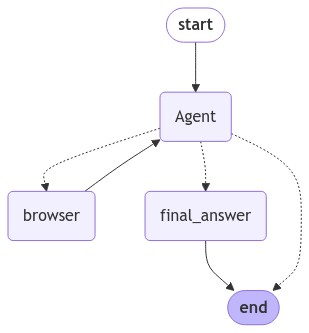

In [210]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(Image(
    g.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)
))

##### Run

In [211]:
out = g.invoke(input={"user_q":q, "chat_history":[]})
out["output"]

--- node_start ---
[{'content': '\n'
             'You know everything, you must answer every question from the '
             'user, you can use the list of tools provided to you.\n'
             'Your goal is to provide the user with the best possible answer, '
             'including key information about the sources and tools used.\n'
             '\n'
             'Note, when using a tool, you provide the tool name and the '
             'arguments to use in JSON format. \n'
             'For each call, you MUST ONLY use one tool AND the response '
             'format must ALWAYS be in the pattern:\n'
             '```json\n'
             '{"name":"<tool_name>", "parameters": '
             '{"<tool_input_key>":<tool_input_value>}}\n'
             '```\n'
             'Remember, do NOT use any tool with the same query more than '
             'once.\n'
             "Remember, if the user doesn't ask a specific question, you MUST "
             'use the `final_answer` tool directl


KeyboardInterrupt



In [8]:
from langchain_community.tools import DuckDuckGoSearchRun

@tool("tool_browser")
def tool_browser(q: str) -> str:
    """Search on DuckDuckGo browser"""
    return DuckDuckGoSearchRun().run(q)

@tool("tool_instagram")
def tool_instagram(q: str) -> str:
    '''Search on Instagram'''
    return DuckDuckGoSearchRun().run(f"site:instagram.com {q}")

print('\x1b[1;31m'+'Browser:'+'\x1b[0m', tool_browser(q) )
print('\n\x1b[1;31m'+''+'Instagram:'+'\x1b[0m', tool_instagram(q) )

Browser: 8 Google Employees Invented Modern AI. Here's the Inside ... The Transformer. Attention Is All You Need Figure 1. The goal is to understand why the Transformer was so groundbreaking and how it achieves these capabilities by implementing each part manually, relying only on NumPy without any out-of-the-box packages from Keras or PyTorch. Being a deep-learning beginner myself, I will try to add as much ... The transformer model, introduced with the groundbreaking paper 'Attention is All You Need', has revolutionized NLP by shifting the paradigm from sequential processing to parallel attention ... The transformer is an architecture that relies on the concept of attention, a technique used to provide weights to different parts of an input sequence so that a better understanding of its ... The "Attention is All You Need" paper ushered in an era where AI could focus, prioritize, and synthesize information in a manner more akin to human cognition, leading to advanced generative ...

I

In [7]:
import wikipedia

@tool("tool_wikipedia")
def tool_wikipedia(q: str) -> str:
    """Search on Wikipedia"""
    return wikipedia.summary(q)

print( tool_wikipedia(q) )

"Attention Is All You Need" is a 2017 landmark research paper in machine learning authored by eight scientists working at Google. The paper introduced a new deep learning architecture known as the transformer, based on the attention mechanism proposed in 2014 by Bahdanau et al. It is considered a foundational paper in modern artificial intelligence, as the transformer approach has become the main architecture of large language models like those based on GPT. At the time, the focus of the research was on improving Seq2seq techniques for machine translation, but the authors go further in the paper, foreseeing the technique's potential for other tasks like question answering and what is now known as multimodal Generative AI.
The paper's title is a reference to the song "All You Need Is Love" by the Beatles. The name "Transformer" was picked because Uszkoreit liked the sound of that word.
An early design document was titled "Transformers: Iterative Self-Attention and Processing for Various

In [10]:
import requests
import re

@tool("tool_arxiv")
def tool_arxiv(arxiv_id: str) -> str:
    """Gets the abstract from an ArXiv paper given the ID. Useful for finding high-level context about a specific paper."""
    res = requests.get(f"https://export.arxiv.org/abs/{arxiv_id}")
    get_abstract = re.compile(
        r'<blockquote class="abstract mathjax">\s*<span class="descriptor">Abstract:</span>\s*(.*?)\s*</blockquote>',
        re.DOTALL)
    res = get_abstract.search(res.text).group(1)
    return res

print( tool_arxiv("1706.03762") )

The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, based
solely on attention mechanisms, dispensing with recurrence and convolutions
entirely. Experiments on two machine translation tasks show these models to be
superior in quality while being more parallelizable and requiring significantly
less time to train. Our model achieves 28.4 BLEU on the WMT 2014
English-to-German translation task, improving over the existing best results,
including ensembles by over 2 BLEU. On the WMT 2014 English-to-French
translation task, our model establishes a new single-model state-of-the-art
BLEU score of 41.8 after training for 3.5 days on eight GPUs, a small fraction
of the training costs of the best models from the literature. We show that the
Transforme

### 3 - Single Agent

##### Final Answer

In [16]:
@tool("final_answer")
def final_answer(answer: str, add_tool: str = "", add_source: str = ""):
    """Returns a natural language response to the user. There are 3 sections to be returned to the user:
    - `answer`: the final natural language answer to the user's question, should provide as much context as possible.
    - `add_tool`: additional information regarding which tool you used to get the answer.
    - `add_source`: additional information regarding what's the source of the answer.
    """
    return {"answer":answer, "add_tool":add_tool, "add_source":add_source}

print( final_answer("yo") )

{'answer': 'yo', 'add_tool': '', 'add_source': ''}


##### Prompt

In [40]:
prompt = """
You are the oracle, the great AI decision maker. 
Given the user's query you must decide what to do with it based on the list of tools provided to you.

Your goal is to provide the user with the best possible answer.
Including key information about the source of information and the tools used.

Note, when using a tool, you provide the tool name and the arguments to use in JSON format. 
For each call, you MUST ONLY use one tool AND the response format must ALWAYS be in the pattern:
```json
{"name":"<tool_name>", "parameters":{"<tool_input_key>":<tool_input_value>}}
```
Remember, do NOT use any tool with the same query more than once.
Remember, if the user doesn't ask a specific question, you MUST use the `final_answer` tool directly.

Every time the user asks a question, you take note of some keywords in the memory.
Every time you find some information related to the user's question, you take note of some keywords in the memory.

You should aim to collect information from a diverse range of sources before providing the answer to the user. 
Once you have collected plenty of information to answer the user's question use the `final_answer` tool.
"""

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages([
    ("system", prompt),
    MessagesPlaceholder(variable_name="chat_history"),
    ("user", "{input}"),
    ("assistant", "memory: {memory}")
])

##### Agent

In [18]:
import typing
from langchain_core.messages import BaseMessage
from langchain_core.agents import AgentAction
import operator

class AgentState(typing.TypedDict):
    input: str #user's most recent query
    chat_history: list[BaseMessage] #full chat
    intermediate_steps: typing.Annotated[list[tuple[AgentAction, str]], operator.add] #record of all actions it does 

In [41]:
import ollama
from pprint import pprint

def get_tools(prompt: str, lst_tools: list[dict]):
    str_tools = "\n".join([str(tool) for tool in lst_tools])
    return (f"{prompt}.\n\n You may use the following tools:\n{str_tools}")

res = ollama.chat(model="llama3.1",
                  messages=[{"role":"system", "content":get_tools(prompt=prompt,
                                                        lst_tools=[tool_wikipedia, final_answer])},
                            {"role":"user", "content":"hi"},
                           ], format="json")

pprint(res)

{'created_at': '2024-09-10T15:09:53.824973Z',
 'done': True,
 'done_reason': 'stop',
 'eval_count': 12,
 'eval_duration': 1930824000,
 'load_duration': 45695956,
 'message': {'content': '{"name":"final_answer", "parameters":{}}',
             'role': 'assistant'},
 'model': 'llama3.1',
 'prompt_eval_count': 438,
 'prompt_eval_duration': 29902821000,
 'total_duration': 31898453594}


In [45]:
from pydantic import BaseModel
import json

class AgentAction(BaseModel):
    tool_name: str
    tool_input: dict
    tool_output: str | None = None

    @classmethod
    def from_ollama(cls, ollama_response: dict):
        try:
            output = json.loads(ollama_response["message"]["content"])
            return cls(tool_name=output["name"], tool_input=output["parameters"])
        except Exception as e:
            print(f"Error parsing ollama response:\n{ollama_response}\n")
            raise e

    def __str__(self):
        text = f"Tool: {self.tool_name}\nInput: {self.tool_input}"
        if self.tool_output is not None:
            text += f"\nOutput: {self.tool_output}"
        return text


action = AgentAction.from_ollama(res)
action

AgentAction(tool_name='final_answer', tool_input={}, tool_output=None)

In [46]:
def action_to_message(action: AgentAction):
    assistant_content = json.dumps({"name": action.tool_name, "parameters": action.tool_input})
    assistant_message = {"role": "assistant", "content": assistant_content}
    user_message = {"role": "user", "content": action.tool_output}
    return [assistant_message, user_message]

In [47]:
test_action = AgentAction(
    tool_name="xyz",
    tool_input={"query": "something cool"},
    tool_output="A fascinating tidbit of information"
)
action_to_message(test_action)

[{'role': 'assistant',
  'content': '{"name": "xyz", "parameters": {"query": "something cool"}}'},
 {'role': 'user', 'content': 'A fascinating tidbit of information'}]

### 4 - Memory

In [55]:
def create_scratchpad(intermediate_steps: list[AgentAction]):
    # filter for actions that have a tool_output
    intermediate_steps = [action for action in intermediate_steps if action.tool_output is not None]
    # format the intermediate steps into a "assistant" input and "user" response list
    scratch_pad_messages = []
    for action in intermediate_steps:
        scratch_pad_messages.extend(action_to_message(action))
    return scratch_pad_messages

def call_llm(user_input: str, chat_history: list[dict], intermediate_steps: list[AgentAction]) -> AgentAction:
    # format the intermediate steps into a scratchpad
    scratchpad = create_scratchpad(intermediate_steps)
    # if the scratchpad is not empty, we add a small reminder message to the agent
    if scratchpad:
        scratchpad += [{
            "role": "user",
            "content": (
                f"Please continue, as a reminder my query was '{user_input}'. "
                "Only answer to the original query, and nothing else — but use the "
                "information I provided to you to do so. Provide as much "
                "information as possible in the `answer` field of the "
                "final_answer tool and remember to leave the contact details "
                "of a promising looking restaurant."
            )
        }]
        # we determine the list of tools available to the agent based on whether
        # or not we have already used the search tool
        tools_used = [action.tool_name for action in intermediate_steps]
        tools = []
        if "search" in tools_used:
            # we do this because the LLM has a tendency to go off the rails
            # and keep searching for the same thing
            tools = [final_answer]
            scratchpad[-1]["content"] = " You must now use the final_answer tool."
        else:
            # this shouldn't happen, but we include it just in case
            tools = [tool_wikipedia, final_answer]
    else:
        # this would indiciate we are on the first run, in which case we
        # allow all tools to be used
        tools = [tool_wikipedia, final_answer]
    # construct our list of messages
    messages = [
        {"role": "system", "content": get_tools(prompt=prompt, lst_tools=tools)},
        *chat_history,
        {"role": "user", "content": user_input},
        *scratchpad,
    ]
    res = ollama.chat(
        model="llama3.1",
        messages=messages,
        format="json",
    )
    return AgentAction.from_ollama(res)

In [56]:
# let's fake some chat history and test
out = call_llm(
    chat_history=[
        {"role": "user", "content": "hi there, how are you?"},
        {"role": "assistant", "content": "I'm good, thanks!"},
        {"role": "user", "content": "I'm currently in Rome"},
        {"role": "assistant", "content": "That's great, would you like any help?"},
    ],
    user_input="yes, I'm looking for the best pizzeria near me",
    intermediate_steps=[]
)
out

AgentAction(tool_name='tool_wikipedia', tool_input={'query': 'Best pizzerias in Rome'}, tool_output=None)

### 5 - Graph Logic

### 6 - Multiple Agents